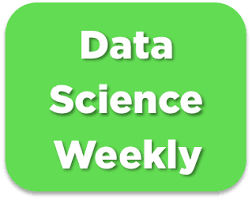

# Challenge : predict conversion rate 🏆🏆

Goal: 
* Create a model that has the best F1 score


# Import libraries

In [1]:
import pandas as pd
import numpy as np

import pickle

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "vscode" # to be replaced by "iframe" if working on jupyter


# Loading & exploring dataset

<a class="anchor" id="first-bullet"></a>


In [2]:
data = pd.read_csv('Data/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [5]:
# Because the dataset is so large, we'll sample it before creating any visualizations
data_sample = data.sample(10000)

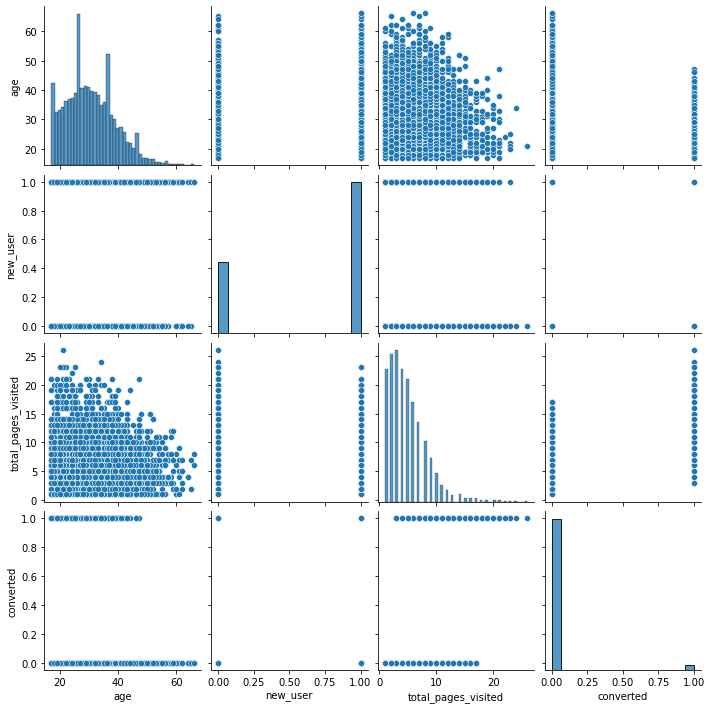

In [6]:
sns.pairplot(data_sample)

In [7]:
#Let's have a closer look at the numbers of conversion rate per country
country_grouped = data.groupby('country')['country','converted'].agg({'converted':['sum','count']})
country_grouped.columns = [ '_'.join(x) for x in country_grouped.columns ] #getting rid of multiindex and concatenating previous column name with function
country_grouped['Proportion'] = country_grouped['converted_sum'] * 100 /country_grouped['converted_count'] 
country_grouped.sort_values('Proportion',ascending=False)

<ipython-input-7-8820eb89a115>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,converted_sum,converted_count,Proportion
country,,,
Germany,730,11693,6.243051
UK,2291,43641,5.249651
US,6070,160124,3.790812
China,89,69122,0.128758


Looks like the country feature would be a good fit in our model as Germany/UK indeed have significantly higher conversion rate than that of China. Let's now look at the age

In [8]:
# Quick look at the distribution of the variable 'age'
fig = px.histogram(data_sample, x="age",width=800, height=400)
fig.show()

In [9]:
bins = pd.cut(data['age'], [17, 20, 25, 30, 35, 40,50,65])
age_df = data.groupby(bins)['age','converted'].agg(['count', 'sum'])
age_df['Conversion Rate'] = age_df[('converted',   'sum')] * 100 / age_df[(      'age', 'count')]
age_df

<ipython-input-9-a23811e83fa0>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



age          converted       Conversion Rate
          count      sum     count   sum                
age                                                     
(17, 20]  25245   481124     25245  1508        5.973460
(20, 25]  55242  1276316     55242  2621        4.744578
(25, 30]  63831  1788172     63831  2142        3.355736
(30, 35]  57093  1878919     57093  1347        2.359308
(35, 40]  40302  1523612     40302   687        1.704630
(40, 50]  31818  1405767     31818   357        1.122006
(50, 65]   4199   226217      4199    21        0.500119

Age seems to be a strong feature as well - the younger the individual is the most likely he/she is to subscribe

In [10]:
fig = px.violin(data_sample, y="total_pages_visited", x="converted", 
        box=True, 
        hover_data=data_sample.columns)

fig.show()

# Machine Learning - Model training

### A -  Selected features

From the EDA, we know that the most useful features are total_pages_visited, age and country. We'll start by doing models with only those features.

In [11]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [12]:
features_list = ['country','age','total_pages_visited']
numeric_indices = [1,2]
categorical_indices = [0]
target_variable = 'converted'

In [13]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'total_pages_visited'], dtype='object')



In [14]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,stratify = Y, random_state=42)
print("...Done.")


Dividing into train and test sets...
...Done.


In [15]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['China' 30 8]
 ['Germany' 43 5]
 ['US' 41 2]
 ['UK' 29 19]
 ['US' 49 4]]
[['US' 20 5]
 ['China' 28 2]]

[0 0 0 1 0]
[0 0]


## Training pipeline

In [16]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

In [17]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")
X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.06766859  0.93587807  0.          0.          0.        ]
 [ 1.50460508  0.03801145  1.          0.          0.        ]
 [ 1.26271682 -0.85985517  0.          0.          1.        ]
 [-0.18861272  4.22805567  0.          1.          0.        ]
 [ 2.23026985 -0.26127743  0.          0.          1.        ]]


In [18]:
# Do same for test straight away
X_test = preprocessor.transform(X_test)
print(X_test[0:5,:])

[[-1.27710987  0.03801145  0.          0.          1.        ]
 [-0.30955685 -0.85985517  0.          0.          0.        ]
 [-1.398054    0.63658919  0.          0.          0.        ]
 [ 1.86743746  0.63658919  0.          0.          1.        ]
 [-1.63994226 -0.5605663   0.          0.          1.        ]]


# Model 1 - Logistic Regression

In [19]:
# Model 1 
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [20]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)


Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]


In [21]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)


Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]


-- Performance Assessment

In [22]:
model1_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.732658366397592
f1-score on test set :  0.7326732673267328


In [23]:
# Printing Confusion Matrix
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246859   1001]
 [  2907   5355]]

Confusion matrix on test set : 
[[27434   106]
 [  326   592]]



# Model 2 - Decision Tree

In [24]:
# Model 2 -- 
print("Train model...")
grid_search = GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [2, 5, 10]})
grid_search.fit(X_train,Y_train)
print("...Done.")

Train model...
...Done.


In [25]:
# Predictions on training set -- MODEL 2 
print("Predictions on training set...")
Y_train_pred = grid_search.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [26]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid_search.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [27]:
grid_search.best_params_

{'max_depth': 8, 'min_samples_split': 10}

 -- Performance assessment

In [28]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
model2_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7375800471857095
f1-score on test set :  0.7292682926829268


In [29]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246758   1102]
 [  2791   5471]]

Confusion matrix on test set : 
[[27416   124]
 [  320   598]]



# Model 3 - AdaBoost


In [30]:
# ! Long time running
# Best params it found fom the below are {'learning_rate': 1.0, 'n_estimators': 200}

grid = GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [2.0, 1.5, 1.0, 0.5, 0.1],
                         'n_estimators': [50, 100, 150, 200, 300]},
                    cv=3, #save some time
                   verbose=1)

grid.fit(X_train,Y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 25.0min finished


GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [2.0, 1.5, 1.0, 0.5, 0.1],
                         'n_estimators': [50, 100, 150, 200, 300]},
             verbose=1)

In [31]:
print(grid.best_estimator_)
print(grid.best_params_)

AdaBoostClassifier(learning_rate=0.5, n_estimators=300)
{'learning_rate': 0.5, 'n_estimators': 300}


In [32]:
grid = AdaBoostClassifier(learning_rate = 1, n_estimators = 200)
grid.fit(X_train,Y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=200)

In [33]:
# Predictions on training set -- MODEL 3 
print("Predictions on training set...")
Y_train_pred = grid.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

model3_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on train set :  0.7350565428109854
f1-score on test set :  0.7321212121212121


# Testing Models with all of the features

In [34]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [35]:
features_list = ['country','age','new_user','source','total_pages_visited']
numeric_indices = [1,2,4]
categorical_indices = [0,3]

#Separating features & target
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()
print('Target : ',target_variable)

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,stratify = Y, random_state=42)
print("...Done.")
print()

#Pipeline didn't change aside from num_indices/ categorical_indices
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

# Preprocessing
print("Encoding categorical features and standardizing numerical features...")
X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])
X_test = preprocessor.transform(X_test)


Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')

Target :  converted
Dividing into train and test sets...
...Done.

Encoding categorical features and standardizing numerical features...
...Done
[[-1.27650481  0.6761303  -0.2618471   0.          0.          1.
   0.          0.        ]
 [-0.18867057  0.6761303  -0.56090876  0.          0.          0.
   0.          0.        ]
 [ 0.65742272 -1.47900486 -0.56090876  0.          0.          1.
   0.          1.        ]
 [-0.9138934   0.6761303   0.93439955  0.          0.          1.
   0.          1.        ]
 [ 1.26177508  0.6761303  -0.56090876  0.          1.          0.
   0.          0.        ]]


# Model 4  - Decision Tree

In [36]:
# Model 4 
print("Train model...")
grid_search = GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': np.array([1, 2, 3, 4,5,6,7,8,9]),
                         'min_samples_split': [2, 5, 10]})
grid_search.fit(X_train,Y_train)
print("...Done.")

Train model...
...Done.


In [37]:
# Predictions on training set -- MODEL 4 
print("Predictions on training set...")
Y_train_pred = grid_search.predict(X_train)
print("...Done.")
print(Y_train_pred)



Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]


In [38]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid_search.predict(X_test)
print("...Done.")
print(Y_test_pred)

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]


In [39]:
grid_search.best_params_

{'max_depth': 9, 'min_samples_split': 5}

Get Scores

In [40]:
model4_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7706877113866967
f1-score on test set :  0.7582251735587081


In [41]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219486    834]
 [  2217   5127]]

Confusion matrix on test set : 
[[54859   221]
 [  580  1256]]



# Model 5 - Logistic Regression

In [42]:
print("Train model...")

classifier = LogisticRegression() 

classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [43]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)


# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)


Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]
Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]


In [44]:
model5_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7620556939098936
f1-score on test set :  0.7682520448348984


In [45]:
# Confusion matrix
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219462    858]
 [  2295   5049]]

Confusion matrix on test set : 
[[54883   197]
 [  568  1268]]



# Model 6 - XGB Boost, default parameters

In [46]:
XGBreg = XGBClassifier()
XGBreg.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [47]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = XGBreg.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = XGBreg.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [48]:
model6_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.774125926480497
f1-score on test set :  0.7645645645645646


# Model 7 - XGB Boost with Grid Search


In [49]:
XGB_grid = GridSearchCV(estimator=XGBClassifier(),
             param_grid={'learning_rate': [ 1.5, 1.0, 0.5, 0.1, 0.01],
                         'n_estimators': [ 100, 150, 200, 300]},
                    cv=3, #save some time
                   verbose=2)

XGB_grid.fit(X_train,Y_train)

print(XGB_grid.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] learning_rate=1.5, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. learning_rate=1.5, n_estimators=100, total=   8.3s
[CV] learning_rate=1.5, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] .............. learning_rate=1.5, n_estimators=100, total=   8.4s
[CV] learning_rate=1.5, n_estimators=100 .............................
[CV] .............. learning_rate=1.5, n_estimators=100, total=   8.6s
[CV] learning_rate=1.5, n_estimators=150 .............................
[CV] .............. learning_rate=1.5, n_estimators=150, total=  14.2s
[CV] learning_rate=1.5, n_estimators=150 .............................
[CV] .............. learning_rate=1.5, n_estimators=150, total= 2.6min
[CV] learning_rate=1.5, n_estimators=150 .............................
[CV] .............. learning_rate=1.5, n_estimators=150, total=  18.6s
[CV] learning_rate=1.5, n_estimators=200 .............................
[CV] .............. learning_rate=1.5, n_estimators=200, total=  16.4s
[CV] learning_rate=1.5, n_estimators=200 .............................
[CV] .............. learning_rate=1.5, n_estimators=200, total=  19.0s
[CV] learning_rate=1.5, n_estimators=200 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 39.1min finished


{'learning_rate': 0.1, 'n_estimators': 100}


In [50]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = XGB_grid.predict(X_train)
print("...Done.")
print(Y_train_pred)


# Predictions on test set
print("Predictions on test set...")
Y_test_pred = XGB_grid.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]
Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [51]:
model7_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7666390915244041
f1-score on test set :  0.7629427792915532


# Model 8 - ADABOOST with logistic regression

Testing as the logistic regression seemed to had good performance

In [52]:
model8 = AdaBoostClassifier(base_estimator=LogisticRegression())
model8

AdaBoostClassifier(base_estimator=LogisticRegression())

In [53]:
model8.fit(X_train,Y_train,sample_weight=None)

AdaBoostClassifier(base_estimator=LogisticRegression())

In [54]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model8.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model8.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [55]:
model8_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7517461281506226
f1-score on test set :  0.7545203800183878


# Model 9 - ADABoost with Logistic Regression & GridSearch 

The parameter has been somewhat modified to be closer to what was found in Adaboost classifier in model 3.

In [56]:
model9 = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=LogisticRegression()),
             param_grid={'learning_rate': [2.5,2, 1.5, 1.0],
                         'n_estimators': [ 200, 300]},
                    cv=3, #save some time
                   verbose=2)
model9.fit(X_train,Y_train) 
print(model9.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] learning_rate=2.5, n_estimators=200 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. learning_rate=2.5, n_estimators=200, total=123.0min
[CV] learning_rate=2.5, n_estimators=200 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 123.0min remaining:    0.0s


[CV] .............. learning_rate=2.5, n_estimators=200, total= 1.6min
[CV] learning_rate=2.5, n_estimators=200 .............................
[CV] .............. learning_rate=2.5, n_estimators=200, total= 2.2min
[CV] learning_rate=2.5, n_estimators=300 .............................
[CV] .............. learning_rate=2.5, n_estimators=300, total= 3.2min
[CV] learning_rate=2.5, n_estimators=300 .............................
[CV] .............. learning_rate=2.5, n_estimators=300, total= 3.1min
[CV] learning_rate=2.5, n_estimators=300 .............................
[CV] .............. learning_rate=2.5, n_estimators=300, total= 2.6min
[CV] learning_rate=2, n_estimators=200 ...............................
[CV] ................ learning_rate=2, n_estimators=200, total=  51.2s
[CV] learning_rate=2, n_estimators=200 ...............................
[CV] ................ learning_rate=2, n_estimators=200, total=  52.8s
[CV] learning_rate=2, n_estimators=200 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 154.0min finished


{'learning_rate': 1.5, 'n_estimators': 300}


In [57]:
# Inputted/ Hard-coded the best params from grid search above to avoid having to run it again

model9 = AdaBoostClassifier(base_estimator=LogisticRegression(),learning_rate=1.5,n_estimators=200)
model9.fit(X_train,Y_train) 

AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=1.5,
                   n_estimators=200)

In [58]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model9.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model9.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [59]:
model9_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7610485759613205
f1-score on test set :  0.7645092676997874


# Model 10 - Voting

In [60]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

model10 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
model10.fit(X_train, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB())])

In [61]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model10.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model10.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [62]:
model10_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.78397898883782
f1-score on test set :  0.7693208430913349


# Model 11 - Voting soft

In [63]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

model11 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
model11.fit(X_train, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB())],
                 voting='soft')

In [64]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model11.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model11.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [65]:
model11_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7860927633011541
f1-score on test set :  0.7695004382120947


# Model 12 - Voting soft & XGB boost

In [66]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = XGBClassifier()

model12 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2),('Gaus',clf3),('XGB',clf4)], voting='hard')
model12.fit(X_train, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('Gaus', GaussianNB()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_cat...
                                            gpu_id=None, grow_policy=None,
            

In [67]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model12.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model12.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [68]:
model12_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7750807845494851
f1-score on test set :  0.7664057796508127


# Model 14 - PCA and Logistic Regression

In [69]:
# initiate PCA and classifier
pca = PCA()
classifier = LogisticRegression()

# transform / fit

X_train_PCA = pca.fit_transform(X_train)
classifier.fit(X_train_PCA, Y_train)

# transform new data using already fitted pca

X_test_PCA = pca.transform(X_test)

# predict labels using the trained classifier

Y_train_pred = classifier.predict(X_train_PCA)
Y_test_pred = classifier.predict(X_test_PCA)

In [70]:
model14_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set: ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set:  0.7620556939098936
f1-score on test set :  0.7682520448348984


# Model 15 - PCA with voting

In [71]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=150, random_state=1)
clf3 = GaussianNB()


model15 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2),('Gaus',clf3)], voting='soft')

model15.fit(X_train_PCA, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=150,
                                                     random_state=1)),
                             ('Gaus', GaussianNB())],
                 voting='soft')

In [72]:
Y_train_pred = model15.predict(X_train_PCA)
Y_test_pred = model15.predict(X_test_PCA)

model15_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set: ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set:  0.783122737013227
f1-score on test set :  0.766338406445837


# Comparing the scores of all of the models

Now that all of the models are done we'll select the one which performed best. 
Because this challenge targets the F1 score, we'll select the model which achieved the highest F1 score on the test set. 
Then, we'll retrain the best performing model with the same hyperparameters on the whole dataset to avoid 'wasting' any data, and use that model to make the predictions for the challenge. 

In [73]:
print('Comparing test scores')
print()
print('-- Models on selected features:')
print()
print('Model 1 test score:',model1_test_score)
print('Model 2 test score:',model2_test_score)
print('Model 3 test score:',model3_test_score)
print()
print("-- Models on whole dataset:")
print()
print('Model 4 test score:',model4_test_score) 
print('Model 5 test score:',model5_test_score)
print('Model 6 test score:',model6_test_score)
print('Model 7 test score:',model7_test_score)
print('Model 8 test score:',model8_test_score)
print('Model 9 test score:',model9_test_score)
print('Model 10 test score:',model10_test_score)
print('Model 11 test score:',model11_test_score) 
print('Model 12 test score:',model12_test_score)
print('Model 14 test score:',model14_test_score)
print('Model 15 test score:', model15_test_score)



Comparing test scores

-- Models on selected features:

Model 1 test score: 0.7326732673267328
Model 2 test score: 0.7292682926829268
Model 3 test score: 0.7321212121212121

-- Models on whole dataset:

Model 4 test score: 0.7582251735587081
Model 5 test score: 0.7682520448348984
Model 6 test score: 0.7645645645645646
Model 7 test score: 0.7629427792915532
Model 8 test score: 0.7545203800183878
Model 9 test score: 0.7645092676997874
Model 10 test score: 0.7693208430913349
Model 11 test score: 0.7695004382120947
Model 12 test score: 0.7664057796508127
Model 14 test score: 0.7682520448348984
Model 15 test score: 0.766338406445837


# Re-train best model on whole dataset

Some F1 scores are really close from one another, and potentially not even statistically different. I submitted more than one set of predictions for this challenge. However, the code below is just to submit one. Here, we'll use model 11 as it had the highest F1 score. 

### Loading test dataset 

In [74]:
df_test = pd.read_csv('Data/conversion_data_test.csv')
df_test.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


### Preprocessing

In [75]:
# Using same pre-processing as what was used in the model
features_list = ['country','age','new_user','source','total_pages_visited']
numeric_indices = [1,2,4]
categorical_indices = [0,3]

#Separating features & target
X_train = data.loc[:, features_list]
Y_train = data.loc[:, target_variable]

X_test = df_test.loc[:,features_list]
# No y_test available 

# Converting to numpy arrays before training
X_train = X_train.values
X_test = X_test.values

Y_train = Y_train.values

# No need to re-instanciate the preprocessor as it hasn't changed
# All we need to do is refit it on new training data

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(284580, 8)
(284580,)
(31620, 8)
(56916,)


### Training

In [76]:
# Instanciate the model
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

final_model = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

# Training
final_model.fit(X_train, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB())],
                 voting='soft')

### Saving the model

In [77]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))  

### Making predictions to submit

We were asked to submit the predictions as a .csv file and without any index. The file must be named 'conversion_data_test_predictions_[name].csv' 

In [78]:
data = {
    'converted': final_model.predict(X_test)
}

final_preds = pd.DataFrame(columns=['converted'],data=data)
final_preds.to_csv('conversion_data_test_predictions_Lea_Boussekeyt.csv', index=False)

# Final check
final_preds.head()

,converted
0,1
1,0
2,0
3,0
4,0
